In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Data Preparation

In [14]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
# Creates windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Windows the dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffles the dataset
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Batches the dataset
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

### Model Architecture

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


### Model Fitting

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Defines the optimizer
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

In [23]:
# Compiles the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [24]:
# Fits the model
history = model.fit(train_set, 
                    epochs=400, 
#                     callbacks=[lr_schedule]
                   )

Epoch 1/400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 0s 10ms/step - loss: 24.2604 - mae: 24.7560
Epoch 2/400
8/8 [==============================] - 0s 8ms/step - loss: 12.0526 - mae: 12.5430
Epoch 3/400
8/8 [==============================] - 0s 8ms/step - loss: 11.1470 - mae: 11.6368
Epoch 4/400
8/8 [==============================] - 0s 9ms/step - loss: 19.9699 - mae: 20.4646
Epoch 5/400

8/8 [==============================] - 0s 9ms/step - loss: 5.5356 - mae: 6.0160
Epoch 166/400
8/8 [==============================] - 0s 9ms/step - loss: 6.7935 - mae: 7.2758
Epoch 167/400
8/8 [==============================] - 0s 9ms/step - loss: 8.7876 - mae: 9.2807
Epoch 168/400
8/8 [==============================] - 0s 10ms/step - loss: 6.5828 - mae: 7.0644
Epoch 169/400
8/8 [==============================] - 0s 10ms/step - loss: 6.5856 - mae: 7.0727
Epoch 170/400
8/8 [==============================] - 0s 10ms/step - loss: 6.0003 - mae: 6.4847
Epoch 171/400
8/8 [==============================] - 0s 11ms/step - loss: 5.1079 - mae: 5.5844
Epoch 172/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7982 - mae: 5.2740
Epoch 173/400
8/8 [==============================] - 0s 9ms/step - loss: 4.8502 - mae: 5.3251
Epoch 174/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6191 - mae: 5.0997
Epoch 175/400
8/8 [==============================] - 0s 10ms/step - l

Epoch 252/400
8/8 [==============================] - 0s 9ms/step - loss: 4.3636 - mae: 4.8378
Epoch 253/400
8/8 [==============================] - 0s 8ms/step - loss: 4.0546 - mae: 4.5290
Epoch 254/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4977 - mae: 4.9746
Epoch 255/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7569 - mae: 5.2342
Epoch 256/400
8/8 [==============================] - 0s 9ms/step - loss: 6.2171 - mae: 6.7011
Epoch 257/400
8/8 [==============================] - 0s 8ms/step - loss: 5.7837 - mae: 6.2669
Epoch 258/400
8/8 [==============================] - 0s 9ms/step - loss: 6.0781 - mae: 6.5638
Epoch 259/400
8/8 [==============================] - 0s 9ms/step - loss: 4.6266 - mae: 5.1085
Epoch 260/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3976 - mae: 4.8697
Epoch 261/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2274 - mae: 4.7021
Epoch 262/400
8/8 [==============================] - 0s 9m

Epoch 339/400
8/8 [==============================] - 0s 8ms/step - loss: 4.0399 - mae: 4.5122
Epoch 340/400
8/8 [==============================] - 0s 9ms/step - loss: 3.9341 - mae: 4.4051
Epoch 341/400
8/8 [==============================] - 0s 9ms/step - loss: 4.3709 - mae: 4.8482
Epoch 342/400
8/8 [==============================] - 0s 11ms/step - loss: 4.7945 - mae: 5.2722
Epoch 343/400
8/8 [==============================] - 0s 8ms/step - loss: 4.9320 - mae: 5.4131
Epoch 344/400
8/8 [==============================] - 0s 9ms/step - loss: 4.5963 - mae: 5.0700
Epoch 345/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2566 - mae: 4.7304
Epoch 346/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3483 - mae: 4.8253
Epoch 347/400
8/8 [==============================] - 0s 9ms/step - loss: 3.9130 - mae: 4.3900
Epoch 348/400
8/8 [==============================] - 0s 8ms/step - loss: 4.0758 - mae: 4.5480
Epoch 349/400
8/8 [==============================] - 0s 8m

In [27]:
history.history

{'loss': [24.260414123535156,
  12.05262279510498,
  11.147007942199707,
  19.96990966796875,
  17.129045486450195,
  14.855547904968262,
  13.955291748046875,
  10.597919464111328,
  11.634056091308594,
  8.25393009185791,
  12.80421257019043,
  17.18376922607422,
  15.625503540039062,
  12.953516006469727,
  11.415090560913086,
  9.53236198425293,
  12.508659362792969,
  12.745250701904297,
  11.150727272033691,
  11.05319595336914,
  8.388267517089844,
  6.681829929351807,
  6.915469646453857,
  8.676712989807129,
  8.378364562988281,
  11.632832527160645,
  12.058688163757324,
  9.215270042419434,
  6.512152671813965,
  6.777239799499512,
  9.6754789352417,
  8.639561653137207,
  8.059368133544922,
  7.510626316070557,
  8.443265914916992,
  6.269047737121582,
  5.384463787078857,
  6.796077728271484,
  6.456754207611084,
  5.793290138244629,
  6.530928134918213,
  11.397170066833496,
  7.805503845214844,
  6.095007419586182,
  5.153385639190674,
  5.017698764801025,
  6.3871665000

### Model Evaluation

In [25]:
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

KeyError: 'lr'

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


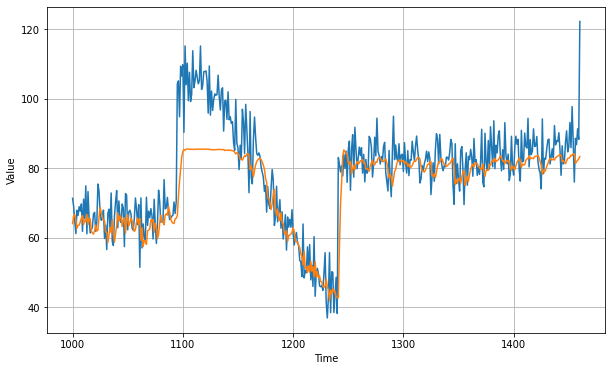

In [28]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.372904

<Figure size 432x288 with 0 Axes>

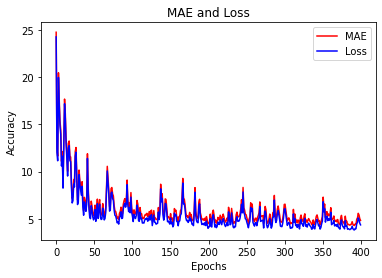

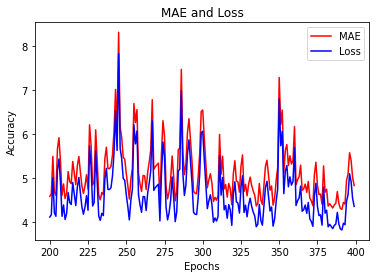

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()